In [1]:
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np

In [2]:
# path to the Million Song Dataset subset (uncompressed)
msd_subset_path='/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/'
msd_subset_data_path='/Users/sw_k_jung/Google Drive/Cloud/CSE546/data')
msd_subset_addf_path=os.path.join(msd_subset_path,'helpers')
msd_code_path='/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/helpers/MSongsDB'
sys.path.append(os.path.join(msd_code_path,'PythonSrc') )
import hdf5_getters as GETTERS

def getSamples(basedir):
    X, Y = [],[]
    feature_labels = ['segments_pitch', 
                 'segments_timbre',
                 'segments_loudness_max',
                 'tempo']
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*.h5'))
        print(root)
        # apply function to all files
        for f in files :
            h5 = GETTERS.open_h5_file_read(f)
            segments_pitch = GETTERS.get_segments_pitches(h5)
            segments_timbre = GETTERS.get_segments_timbre(h5)
            segments_loudness_max = GETTERS.get_segments_loudness_max(h5)
            tempo = GETTERS.get_tempo(h5)
            year = GETTERS.get_year(h5)
            h5.close()
            X.append([segments_pitch,segments_timbre,segments_loudness_max,tempo])      
            Y.append(year)
    return X, Y, feature_labels

X, Y, labels = getSamples(msd_subset_data_path)

/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/R
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/U
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/I
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/N
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/G
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/Z
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/T
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/S
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/A
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/F
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/O
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/H
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/R/M
/Users/sw_k_jung/Goo

/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/G/L
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/G/Y
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/G/P
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/G/W
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/R
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/U
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/I
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/N
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/G
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/Z
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/T
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/S
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/A
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/F
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/Z/O
/Users/sw_

/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/F/K
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/F/L
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/F/Y
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/F/P
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/F/W
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O/R
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O/U
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O/I
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O/N
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O/G
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O/Z
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O/T
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O/S
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O/A
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/O/F
/Users/sw_

/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/C/E
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/C/B
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/C/K
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/C/L
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/C/Y
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/C/P
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/C/W
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/D
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/D/R
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/D/U
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/D/I
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/D/N
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/D/G
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/D/Z
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/D/T
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/D/S
/Users/sw_

/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/E/Q
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/E/X
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/E/E
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/E/B
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/E/K
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/E/L
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/E/Y
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/E/P
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/E/W
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/B
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/B/R
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/B/U
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/B/I
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/B/N
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/B/G
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/B/Z
/Users/sw_

/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/D
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/V
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/Q
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/X
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/E
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/B
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/K
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/L
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/Y
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/P
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/P/W
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/W
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/W/R
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/W/U
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/W/I
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/A/W/N
/Users/sw_

/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/U
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/I
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/N
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/G
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/Z
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/T
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/S
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/A
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/F
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/O
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/H
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/M
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/J
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/C
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/D
/Users/sw_k_jung/Google Drive/Cloud/CSE546/Project/data/B/H/V
/Users/s

In [9]:
print(len(X), len(Y))
print(X[2][0].shape)

10000 10000
(205, 12)


4680


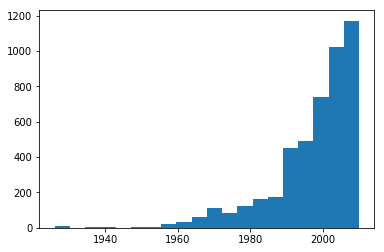

In [15]:
import matplotlib.pyplot as plt
import copy
# Generate a normal distribution, center at x=0 and y=5

X_filtered = []
Y_filtered = []
for i, year in enumerate(Y):
    if year != 0:
        X_filtered.append(X[i])
        Y_filtered.append(Y[i])
print(len(Y_filtered))
plt.hist(Y_filtered, bins=20)
plt.show()